In [1]:
# Import our dependencies
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_circles

# Creating dummy nonlinear data
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, random_state=78)

# Transforming y_circles to a vertical vector
y_circles = y_circles.reshape(-1, 1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

<AxesSubplot:xlabel='Feature 1', ylabel='Feature 2'>

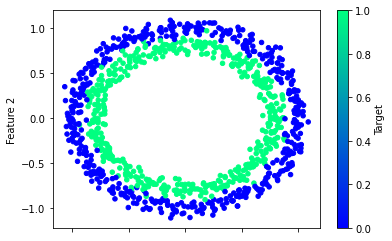

In [2]:
# Creating a DataFrame to plot the nonlinear dummy data
df_circles = pd.DataFrame(X_circles, columns=["Feature 1", "Feature 2"])
df_circles["Target"] = y_circles

# Plot the nonlinear dummy data
df_circles.plot.scatter(x="Feature 1",y="Feature 2", c="Target",colormap="winter")

In [3]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [4]:
# Import the kerastuner library
import kerastuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2,
    overwrite=True)

<ipython-input-4-c86af238e0b3>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [5]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 01s]
val_accuracy: 0.9679999947547913

Best val_accuracy So Far: 0.9679999947547913
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


In [6]:
# Get top three model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 26, 'num_layers': 5, 'units_0': 26, 'units_1': 11, 'units_2': 26, 'units_3': 6, 'units_4': 6, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 26, 'num_layers': 2, 'units_0': 11, 'units_1': 16, 'units_2': 26, 'units_3': 21, 'units_4': 16, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 21, 'num_layers': 2, 'units_0': 11, 'units_1': 21, 'units_2': 6, 'units_3': 21, 'units_4': 26, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [7]:
# Evaluate the top three models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.3320 - accuracy: 0.9680
Loss: 0.33204638957977295, Accuracy: 0.9679999947547913
8/8 - 0s - loss: 0.4220 - accuracy: 0.9600
Loss: 0.42199981212615967, Accuracy: 0.9599999785423279
8/8 - 0s - loss: 0.5319 - accuracy: 0.8160
Loss: 0.5318801999092102, Accuracy: 0.8159999847412109


In [8]:
# Get second best model hyperparameters
second_hyper = tuner.get_best_hyperparameters(2)[1]
second_hyper.values

{'activation': 'relu',
 'first_units': 26,
 'num_layers': 2,
 'units_0': 11,
 'units_1': 16,
 'units_2': 26,
 'units_3': 21,
 'units_4': 16,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [9]:
# Compare the performance to the second-best model
second_model = tuner.get_best_models(2)[1]
model_loss, model_accuracy = second_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.4220 - accuracy: 0.9600
Loss: 0.42199981212615967, Accuracy: 0.9599999785423279
